### Using Word Embeddings

Word embeddings, numerical representations of words based on deep learning neural networks, have revolutionized natural language processing over the last eight years. Literally, every application of NLP has been transformed by this technology. We'll start modestly, using the numerical notion of distance to understand political speech. 

Our goal is multi-step: 

1. Scrape all speeches from the DNC and RNC national conventions. Good news, that's already done.
1. Convert each speech giver in a numeric value, based on the words they delivered at the convention.
1. Measure their distance to the speeches of Donald Trump and Joe Biden.
1. Visualize speech givers along these dimensions.

A good reference for word embeddings in spaCy can be found in [the documentation](https://spacy.io/usage/vectors-similarity). 

In [1]:
import sqlite3
from collections import defaultdict
import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Load the parser up here, so we don't keep reloading it as 
# we run cells down below.
nlp = spacy.load("en_core_web_md")

## Gather the Data

Let's query the database (a copy of which is up on Moodle) and create a dictionary to store the data. The key should be the speaker and the value should be a string containing _everything_ they said at the convention.

In [4]:
db = sqlite3.connect("2020_Conventions.db")
cur = db.cursor()

In [5]:
convention_data = cur.execute("""
                                SELECT speaker, party, text 
                                FROM conventions
                                """)


In [6]:
speeches = defaultdict(str)
party_lu = defaultdict(str)

for item in convention_data :
    speaker, party, text = item
    
    speeches[speaker] = " ".join([speeches[speaker],text]).strip() 
    party_lu[speaker] = party

Some people appeared in both conventions via video clips. Let's make sure they all have the correct party.

In [7]:
party_lu["Donald Trump"] = "Republican"
party_lu["Andrew Cuomo"] = "Democratic"
party_lu["Joe Biden"] = "Democratic"
party_lu["Nancy Pelosi"] = "Democratic"

Let's remove any speaker who spoke fewer than `length_cutoff` words at the convention or whose name we don't know.

In [8]:
length_cutoff = 100
to_remove = []
num_removed = 0
num_kept = 0

for speaker, text in speeches.items() :
    text_len = len(text.split())
    
    if (text_len < length_cutoff or 
        "Speaker" in speaker or 
        "Unknown" in speaker) :
        num_removed += 1
        to_remove.append(speaker)
    else :
        num_kept += 1

In [9]:
print(num_kept)

239


In [10]:
print(num_removed)

317


In [11]:
for speaker in to_remove :
    del speeches[speaker]


In [12]:
db.close()

## Creating a Numeric Vector

Now let's turn each speaker into a numeric vector. There are many ways we could potentially do this. We'll follow one of the most straightforward. We'll do some cleaning, convert each word of their speech into a vector, and average those vectors. 

We'll use the spaCy library's vectorization of words. Note that the small library (`en_core_web_sm`), doesn't include the word vectorization, so you'll need to have downloaded either the medium or large model. You can do this at the command line by running `python -m spacy download en_core_web_md`. The large model is _large_; it'll take a long time to download.

For cleaning, there are a variety of things we could try: 

* Removing stopwords using the `token.is_stop` attribute in spaCy.
* Removing punctuation using `token.is_punct`
* Keeping only certain parts of speech (like nouns and/or verbs)

We're going to take these averages, but let's first play around with one person's speech and the tokens from it.

In [13]:
text = speeches["Michelle Obama"]
tokens = nlp(text)
token = tokens[8]

In [14]:
print(token)
print(token.vector)

country
[ 7.3677e-02  5.2156e-01  3.1504e-01 -2.5743e-01  6.3185e-01 -1.4061e-01
  4.4108e-02  5.5817e-02 -4.5327e-01  3.3915e+00 -8.8491e-01  1.4696e-02
 -4.4164e-01 -2.7146e-01  6.5846e-02 -1.4115e-01 -1.8359e-01  5.5882e-01
  3.4735e-01  4.9206e-01 -2.9363e-01  1.5864e-01  1.8245e-01  2.4616e-01
 -5.4651e-02 -2.6116e-01 -2.0582e-01  1.7782e-01 -2.3421e-01  2.0985e-01
  3.4395e-01 -7.5486e-03  1.1200e-01 -4.3141e-01  7.9923e-02 -1.0038e-01
 -1.5685e-01 -2.8106e-01  1.3058e-01  4.1862e-01 -8.8605e-02  2.7584e-01
  2.5731e-01  1.9394e-01 -2.0442e-01 -4.4856e-01  4.8795e-01 -2.4139e-01
  9.9646e-02 -3.3894e-01 -6.3024e-01  2.4977e-01 -4.6698e-02 -3.4425e-01
  3.9504e-01 -1.0694e-01  1.5900e-01 -2.0601e-01  3.7994e-01 -1.8441e-01
 -1.1135e-02  4.4415e-01 -1.6894e-01  4.8023e-01 -1.4859e-01  2.5886e-01
 -1.5207e-01  6.8721e-02  3.1572e-01  9.3189e-02 -1.5450e-01  1.5372e-01
  8.5520e-02  7.5760e-02  3.7679e-02 -1.1032e-01 -4.6535e-01  6.0151e-02
  2.2266e-01 -5.7096e-02  2.4310e-01  7.750

In [15]:
token.vector.shape

(300,)

Let's iterate over all the tokens in Michelle Obama's speeches and build an average word vector for her. I've set up an empty numpy array of the proper length. Let's sum up the vectors in that score vector. If you divide by the number of tokens you'll get the average word vector. 

In [16]:
score = np.zeros(300)
token_count = 0

for token in tokens :
    score += token.vector
    token_count += 1
    
score = score/token_count
    
print(sum(score))

1.1034043321105758


We can do this more quickly by taking advantage of list comprehensions (making a list of vectors) and simply applying `np.mean` across the list. 

In [17]:
word_vector_list = [token.vector for token in tokens]

In [18]:
average_word_vector = np.mean(word_vector_list, axis=0)

# check that the sum is the same as the other way
print(average_word_vector.sum())

1.1034019


Now let's calculate these average word vectors for each speaker. 

In [19]:
scores = defaultdict(np.array)

for speaker, text in speeches.items() :

    tokens = nlp(text)
    tokens = [t for t in tokens if not t.is_stop and not t.is_punct and t]
    #tokens = [t for t in tokens if t.pos_ in ['NOUN','VERB']]
    
    word_vector_list = [token.vector for token in tokens]
    scores[speaker] = np.mean(word_vector_list, axis=0)
    
    
        

## Measuring Distance

Now we'll create two numpy arrays that measure the distance between each speaker and the presidental candiates. For reasons we'll discuss in class, the cosine similariy is the overwhelming choice for text data. The cosine distance measures the angle between the vectors, disregarding the magnitude of the vectors. As you may recall from high school algebra, one formula for the cosine, and the one we'll use, is this: 

$$
    \cos(a,b) = \frac{a \cdot b}{||a||\cdot||b||}
$$

In [20]:
def cosine_dist(a,b) :
    dist = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return(dist)

In [21]:
trump_dists = np.zeros(len(scores))
biden_dists = np.zeros(len(scores))
speakers = []
party = []

for idx, speaker in enumerate(scores) :
    this_vec = scores[speaker]
    speakers.append(speaker)
    party.append(party_lu[speaker])
    
    trump_dists[idx] = cosine_dist(scores["Donald Trump"],this_vec)
    biden_dists[idx] = cosine_dist(scores["Joe Biden"],this_vec)
        

spaCy includes a similarity measure based on the cosine distance. You can feed two tokens in and receive the similarity score between them. How could you potentially use this functionality to measure the similarity between speakers?

In [22]:
print(nlp("young").similarity(nlp("old")))
print(nlp("dog").similarity(nlp("cat")))
print(nlp("dog").similarity(nlp("justice")))
print(nlp("inequality").similarity(nlp("justice")))

0.5337057376173076
0.8016854705531046
0.18886675407714953
0.400489786535697


Now let's visualize these distances to get a sense of the distributions.

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,
         1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  5.,  0.,  2.,  5.,
         3.,  5.,  4.,  4.,  6.,  9.,  7.,  9.,  6.,  5.,  3.,  6.,  8.,
        10.,  5.,  6.,  3.,  2.,  9.,  9.,  4.,  8.,  9.,  6., 17.,  7.,
         9.,  6.,  5.,  5.,  1.,  1.,  1.,  0.,  1.]),
 array([0.77294505, 0.7752156 , 0.77748615, 0.7797567 , 0.78202724,
        0.78429779, 0.78656834, 0.78883889, 0.79110944, 0.79337999,
        0.79565054, 0.79792109, 0.80019164, 0.80246219, 0.80473274,
        0.80700329, 0.80927384, 0.81154439, 0.81381494, 0.81608549,
        0.81835604, 0.82062659, 0.82289714, 0.82516769, 0.82743824,
        0.82970878, 0.83197933, 0.83424988, 0.83652043, 0.83879098,
        0.84106153, 0.8433

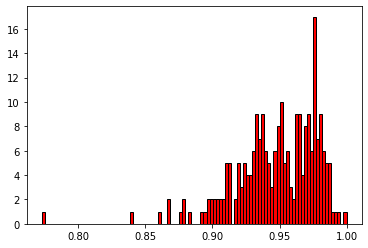

In [23]:
# matplotlib histogram
plt.hist(trump_dists, 
         color = 'red', 
         edgecolor = 'black',
         bins = 100)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  2.,  0.,
         1.,  1.,  0.,  1.,  1.,  2.,  2.,  3.,  1.,  1.,  1.,  2.,  4.,
         6.,  2.,  2.,  3.,  4.,  2.,  3.,  9.,  4.,  5.,  5., 10., 12.,
         5.,  8.,  6.,  9.,  7.,  6., 10., 13.,  8., 11.,  4., 11., 11.,
         7.,  7.,  5.,  7.,  1.,  2.,  2.,  0.,  1.]),
 array([0.7558887 , 0.75832981, 0.76077092, 0.76321204, 0.76565315,
        0.76809426, 0.77053537, 0.77297648, 0.77541759, 0.77785871,
        0.78029982, 0.78274093, 0.78518204, 0.78762315, 0.79006427,
        0.79250538, 0.79494649, 0.7973876 , 0.79982871, 0.80226982,
        0.80471094, 0.80715205, 0.80959316, 0.81203427, 0.81447538,
        0.8169165 , 0.81935761, 0.82179872, 0.82423983, 0.82668094,
        0.82912205, 0.8315

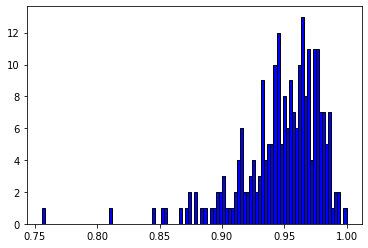

In [24]:
# matplotlib histogram
plt.hist(biden_dists, 
         color = 'blue', 
         edgecolor = 'black',
         bins = 100)

For both speakers, most similarities are quite high; the values range from zero to one. Let's figure out which speakers are closest to both Trump and Biden. One way to do this is to put everything in a data frame and do some sorting. 

In [25]:
distances = pd.DataFrame(list(zip(speakers,party, trump_dists.tolist(),biden_dists.tolist())),
                         columns=["Speaker","Party","TrumpDist","BidenDist"])

In [26]:
# Far from Trump
distances.sort_values("TrumpDist").head(n=10)

,Speaker,Party,TrumpDist,BidenDist
131,Trace Adkins,Republican,0.772945,0.755889
153,Maria Cardona,Democratic,0.840596,0.810221
100,Gino,Republican,0.859477,0.879753
151,Bennie Thompson,Democratic,0.867158,0.844989
223,Kyle,Democratic,0.867419,0.901772
52,Imam Al-Hajj Talib Abdur-Rashid,Democratic,0.875826,0.874294
13,Jim Roosevelt,Democratic,0.878443,0.853015
155,Julie Chavez Rodriguez,Democratic,0.879174,0.853666
62,Ghali,Republican,0.883254,0.875465
106,Candidates for naturalizaton,Republican,0.892249,0.867585


In [27]:
# Close to Trump
distances.sort_values("TrumpDist").tail(n=10)

,Speaker,Party,TrumpDist,BidenDist
60,Narrator,Republican,0.986358,0.972364
4,Joe Biden,Democratic,0.987339,1.000000
78,Nikki Haley,Republican,0.987374,0.979265
107,Eric Trump,Republican,0.987550,0.977181
149,Ivanka Trump,Republican,0.987721,0.990286
6,Barack Obama,Democratic,0.988619,0.993064
133,Kevin McCarthy,Republican,0.989419,0.987306
121,Madison Cawthorn,Republican,0.990918,0.988541
98,Mike Pence,Republican,0.994166,0.981896
28,Donald Trump,Republican,1.000000,0.987339


In [28]:
# Far from Biden
distances.sort_values("BidenDist").head(n=10)

,Speaker,Party,TrumpDist,BidenDist
131,Trace Adkins,Republican,0.772945,0.755889
153,Maria Cardona,Democratic,0.840596,0.810221
151,Bennie Thompson,Democratic,0.867158,0.844989
13,Jim Roosevelt,Democratic,0.878443,0.853015
155,Julie Chavez Rodriguez,Democratic,0.879174,0.853666
106,Candidates for naturalizaton,Republican,0.892249,0.867585
188,Intro,Democratic,0.901533,0.872890
52,Imam Al-Hajj Talib Abdur-Rashid,Democratic,0.875826,0.874294
62,Ghali,Republican,0.883254,0.875465
180,Josh Abernathy,Democratic,0.897067,0.878913


In [29]:
# Close to Biden
distances.sort_values("BidenDist").tail(n=10)

,Speaker,Party,TrumpDist,BidenDist
142,Ann Dorin,Republican,0.981874,0.987249
133,Kevin McCarthy,Republican,0.989419,0.987306
28,Donald Trump,Republican,1.000000,0.987339
16,Andrew Yang,Democratic,0.976899,0.987484
121,Madison Cawthorn,Republican,0.990918,0.988541
149,Ivanka Trump,Republican,0.987721,0.990286
2,Michelle Obama,Democratic,0.973017,0.992036
7,Kamala Harris,Democratic,0.985397,0.992770
6,Barack Obama,Democratic,0.988619,0.993064
4,Joe Biden,Democratic,0.987339,1.000000


Take a look at the speakers who are close and far from the presidential candidates. Do these make sense to you? Play around with the filtering options at the end of the "Creating a Numeric Vector" section. What combinations seem to make the most sense?

## Plotting Distances

Most speakers are pretty similar to each other. Let's make a plot of the distances to Trump and Biden to get a sense of the correlational and overall space of distances.

Text(0, 0.5, 'Biden Distances')

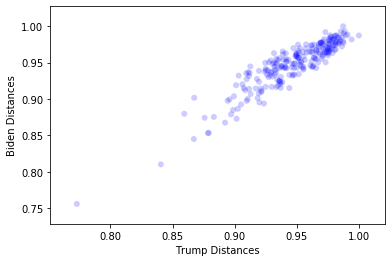

In [30]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(trump_dists,biden_dists , c='blue', alpha=0.2, edgecolors='none')
ax.set_xlabel("Trump Distances")
ax.set_ylabel("Biden Distances")


## Recommendation Engines

Brenden asked me to post this assignment "as early as feasible" so that he could use these ideas to recommend songs. Here we are, last day of classes, and I'm posting this exercise. Sorry Brenden!

But the ideas in this exercise can work directly for recommendation engines. Who are the five speakers who are most similar to Biden? How could you use this for song lyrics?


In [31]:
distances.sort_values("BidenDist").tail(n=6)

,Speaker,Party,TrumpDist,BidenDist
121,Madison Cawthorn,Republican,0.990918,0.988541
149,Ivanka Trump,Republican,0.987721,0.990286
2,Michelle Obama,Democratic,0.973017,0.992036
7,Kamala Harris,Democratic,0.985397,0.992770
6,Barack Obama,Democratic,0.988619,0.993064
4,Joe Biden,Democratic,0.987339,1.000000
